In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, "src")

from pandas import DataFrame
from analytics.metrics.metric import MetricCalculator
from analytics.metrics.time import TimeMetrics
from spec.enums import MainTableColumns as Cols
from spec.spec_definition import PS2Versions

In [ ]:
from database.config import PS2DataConfig

spec = PS2Versions.v1_0.load()

# data_config = PS2DataConfig.from_yaml("sample_data_configs/cwo_s19.yaml", spec)


In [3]:
from analytics.ps2_dataset import PS2Dataset

dataset = PS2Dataset(spec, data_config)

In [4]:
# TODO: Add timezone preprocessor to the dataset

main_table = dataset.get_main_table()
main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,Attempt,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
0,0,f40a635828e2bffd0a598a7ed621fc93,Java 8; CodeWorkout,2019-03-20 19:34:25,0,CS 1,1,492.0,32,25,548938774dc948448b0bb51139bbcae3a3966ab8,True,Run.Program,1.0,NaN,NaN,NaN,32-84779,NaN,NaN
1,1,f40a635828e2bffd0a598a7ed621fc93,Java 8; CodeWorkout,2019-03-20 19:34:25,0,CS 1,1,492.0,32,25,548938774dc948448b0bb51139bbcae3a3966ab8,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN
2,2,f18374bf891c9af64c8570448824202d,Java 8; CodeWorkout,2019-03-20 21:02:00,0,CS 1,2,492.0,32,1,20dc599067ac07408b5636973fc6b8a37db9af32,True,Run.Program,1.0,NaN,NaN,NaN,32-84781,NaN,NaN
3,3,f18374bf891c9af64c8570448824202d,Java 8; CodeWorkout,2019-03-20 21:02:00,0,CS 1,2,492.0,32,1,20dc599067ac07408b5636973fc6b8a37db9af32,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN
4,4,4d230b683bf9840553ae57f4acc96e81,Java 8; CodeWorkout,2019-03-20 21:13:09,0,CS 1,1,492.0,32,1,23c57b36002c4d482df3d25f97778f74a2ed581a,True,Run.Program,0.0,NaN,NaN,NaN,32-84783,NaN,NaN


In [5]:
main_table.ServerTimestamp.iloc[0]

Timestamp('2019-03-20 19:34:25')

In [6]:
student_subset = main_table[Cols.SubjectID].unique()[:50]
mt_subset = main_table[main_table[Cols.SubjectID].isin(student_subset)]

<Axes: ylabel='Frequency'>

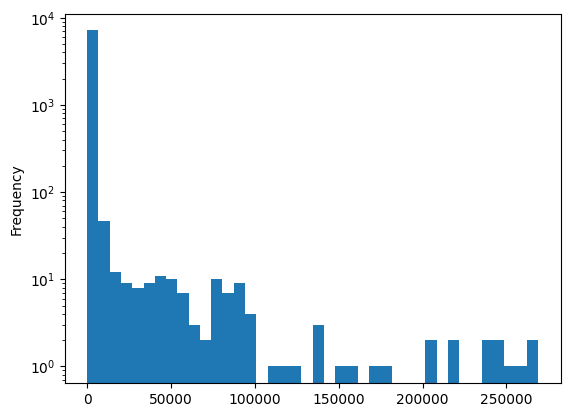

In [36]:
from analytics.metrics.time import TimeMetrics

diffs = TimeMetrics.get_all_diffs(mt_subset, Cols.ServerTimestamp, [Cols.SubjectID, Cols.ProblemID])
diffs.DeltaSeconds[diffs.DeltaSeconds > 0].plot.hist(bins=40, log=True)

In [ ]:
TimeMetrics.get_positive_diff_quantiles(mt_subset, Cols.ServerTimestamp, [Cols.SubjectID, Cols.ProblemID]) / 60

# Seems like 5 minutes (90th+ percentile) is a good cutoff for time spent on a problem between submissions
# 30m does seem to suggest that the student is not working on the problem

0.00       0.016667
0.25       0.266667
0.50       0.566667
0.75       1.416667
0.80       1.850000
0.85       2.533333
0.90       4.150000
0.95      12.165000
0.96      21.898000
0.97      44.538000
0.98     152.534667
0.99     793.671333
1.00    4482.116667
Name: DeltaSeconds, dtype: float64

In [ ]:
time_metrics = TimeMetrics(5*60, 30 * 60, True, Cols.ServerTimestamp)

# time_metrics.test_calculation(mt_subset, [Cols.SubjectID, Cols.ProblemID])

result = main_table.groupby([Cols.SubjectID, Cols.ProblemID]).apply(lambda x: time_metrics.calculate(x))
result

C:\Users\twprice\AppData\Local\Temp\ipykernel_18296\3841107816.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = main_table.groupby([Cols.SubjectID, Cols.ProblemID]).apply(lambda x: time_metrics.calculate(x))


ActiveTime  IdleTime  TotalTime  \
SubjectID                        ProblemID                                    
00c54f9462673d4c09d2a88121860841 1                 0.0       0.0        0.0   
                                 3                 0.0       0.0        0.0   
                                 5                37.0       0.0       37.0   
                                 12                0.0       0.0        0.0   
                                 13              421.0       0.0      421.0   
...                                                ...       ...        ...   
ffb72475a81de0e95b910ffad039f5c2 232            1630.0     571.0     2201.0   
                                 233             120.0       0.0      120.0   
                                 234              40.0       0.0       40.0   
                                 235            1065.0       0.0     1065.0   
                                 236               0.0       0.0        0.0   

                                            ActiveTimeAfterCorrect  #Breaks  \
SubjectID                        ProblemID                                    
00c54f9462673d4c09d2a88121860841 1                             0.0        0   
                                 3                             0.0        0   
                                 5                             0.0        0   
                                 12                           31.0        0   
                                 13                            0.0        0   
...                                                            ...      ...   
ffb72475a81de0e95b910ffad039f5c2 232                           0.0        2   
                                 233                           0.0        0   
                                 234                           0.0        0   
                                 235                           0.0        0   
                                 236                           0.0        0   

                                                     StartTime  \
SubjectID                        ProblemID                       
00c54f9462673d4c09d2a88121860841 1         2019-02-24 05:13:03   
                                 3         2019-02-24 05:13:33   
                                 5         2019-02-24 05:09:54   
                                 12        2019-02-24 05:14:37   
                                 13        2019-02-24 04:27:49   
...                                                        ...   
ffb72475a81de0e95b910ffad039f5c2 232       2019-02-24 07:04:21   
                                 233       2019-02-25 01:52:23   
                                 234       2019-02-25 01:25:54   
                                 235       2019-02-24 23:37:59   
                                 236       2019-02-25 01:32:22   

                                              FirstCorrectTime  \
SubjectID                        ProblemID                       
00c54f9462673d4c09d2a88121860841 1         2019-02-24 05:13:03   
                                 3         2019-02-24 05:13:33   
                                 5         2019-02-24 05:10:31   
                                 12        2019-02-24 05:14:37   
                                 13        2019-02-24 04:34:50   
...                                                        ...   
ffb72475a81de0e95b910ffad039f5c2 232       2019-02-25 01:18:45   
                                 233       2019-02-25 01:54:23   
                                 234       2019-02-25 01:26:34   
                                 235       2019-02-24 23:55:44   
                                 236       2019-02-25 01:32:22   

                                                       EndTime    n  
SubjectID                        ProblemID                           
00c54f9462673d4c09d2a88121860841 1         2019-02-24 05:13:03    2  
                                 3         2019-02-24 05:13:

In [ ]:
result.describe()

,ActiveTime,IdleTime,TotalTime,ActiveTimeAfterCorrect,#Breaks,StartTime,FirstCorrectTime,EndTime,n
count,16179.000000,16179.000000,16179.000000,16179.000000,16179.000000,16179,15024,16179,16179.000000
mean,151.546202,103.415230,254.961431,5.629582,0.105260,2019-03-25 08:43:05.772235520,2019-03-25 06:04:12.134584576,2019-03-25 10:19:15.913838848,12.458743
min,0.000000,0.000000,0.000000,0.000000,0.000000,2019-02-20 17:40:39,2019-02-20 21:17:01,2019-02-20 21:17:01,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2019-03-05 03:18:51.500000,2019-03-04 22:48:57.500000,2019-03-05 13:51:58,2.000000
50%,24.000000,0.000000,27.000000,0.000000,0.000000,2019-03-24 16:04:34,2019-03-24 15:10:30.500000,2019-03-24 17:40:09,5.000000
75%,174.000000,0.000000,221.000000,0.000000,0.000000,2019-04-12 16:47:03.500000,2019-04-12 17:31:59,2019-04-12 18:09:35,14.000000
max,5455.000000,5100.000000,8353.000000,2752.000000,7.000000,2019-05-06 03:58:08,2019-05-06 03:58:44,2019-05-06 03:58:44,556.000000
std,306.605587,380.144603,590.146583,48.424146,0.394653,NaN,NaN,NaN,21.031547
